In [383]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.exceptions import FitFailedWarning
import warnings
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)

In [384]:
traffic_data = pd.read_csv('../Dataset/Traffic_dataset_cleaned.csv')

In [385]:
traffic_data.head()

,Date,Area Name,Road/Intersection Name,Traffic Volume,Average Speed,Travel Time Index,Congestion Level,Road Capacity Utilization,Incident Reports,Environmental Impact,Public Transport Usage,Traffic Signal Compliance,Parking Usage,Pedestrian and Cyclist Count,Weather Conditions,Roadwork and Construction Activity
0,2023-01-01,Indiranagar,100 Feet Road,38088,34.524677,1.500000,100.000000,100.000000,0,126.176,50.469754,76.115968,53.046862,112,Clear,No
1,2023-01-01,Indiranagar,CMH Road,11455,55.238811,1.289785,29.481069,57.513253,1,72.910,23.808131,63.963246,92.954398,189,Clear,Yes
2,2023-01-01,Koramangala,Sarjapur Road,57026,41.124461,1.500000,100.000000,100.000000,0,164.052,59.848915,81.218365,80.047490,107,Clear,No
3,2023-01-01,Electronic City,Hosur Road,29119,22.379865,1.500000,100.000000,100.000000,1,108.238,14.226335,90.683292,64.671567,89,Clear,No
4,2023-01-01,M.G. Road,Trinity Circle,41318,31.116683,1.500000,100.000000,100.000000,1,132.636,62.060852,74.137356,63.071886,96,Clear,No


In [386]:
traffic_data['Date'] = pd.to_datetime(traffic_data['Date'])

In [387]:
traffic_data.columns

Index(['Date', 'Area Name', 'Road/Intersection Name', 'Traffic Volume',
       'Average Speed', 'Travel Time Index', 'Congestion Level',
       'Road Capacity Utilization', 'Incident Reports', 'Environmental Impact',
       'Public Transport Usage', 'Traffic Signal Compliance', 'Parking Usage',
       'Pedestrian and Cyclist Count', 'Weather Conditions',
       'Roadwork and Construction Activity'],
      dtype='object')

In [388]:
numeric_cols = traffic_data.select_dtypes(include=['int64','float64']).columns

for col in numeric_cols:
    Q1 = traffic_data[col].quantile(0.25)
    Q3 = traffic_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    outliers = traffic_data[(traffic_data[col] < lower_limit) | (traffic_data[col] > upper_limit)]
    print(f"{col}: {len(outliers)} outliers")


Traffic Volume: 14 outliers
Average Speed: 27 outliers
Travel Time Index: 0 outliers
Congestion Level: 2 outliers
Road Capacity Utilization: 1242 outliers
Incident Reports: 52 outliers
Environmental Impact: 14 outliers
Public Transport Usage: 0 outliers
Traffic Signal Compliance: 0 outliers
Parking Usage: 0 outliers
Pedestrian and Cyclist Count: 853 outliers


In [389]:
print(traffic_data.info())
print(traffic_data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5512 entries, 0 to 5511
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Date                                5512 non-null   datetime64[ns]
 1   Area Name                           5512 non-null   object        
 2   Road/Intersection Name              5512 non-null   object        
 3   Traffic Volume                      5512 non-null   int64         
 4   Average Speed                       5512 non-null   float64       
 5   Travel Time Index                   5512 non-null   float64       
 6   Congestion Level                    5512 non-null   float64       
 7   Road Capacity Utilization           5512 non-null   float64       
 8   Incident Reports                    5512 non-null   int64         
 9   Environmental Impact                5512 non-null   float64       
 10  Public Transport Usage  

# CREATING SCATTER PLOTS FOR VISUAL UNDERSTANDING OF RELATIONS BETWEEN FEATURES

In [390]:
attributes = ['Traffic Volume', 'Average Speed', 'Travel Time Index', 'Congestion Level']

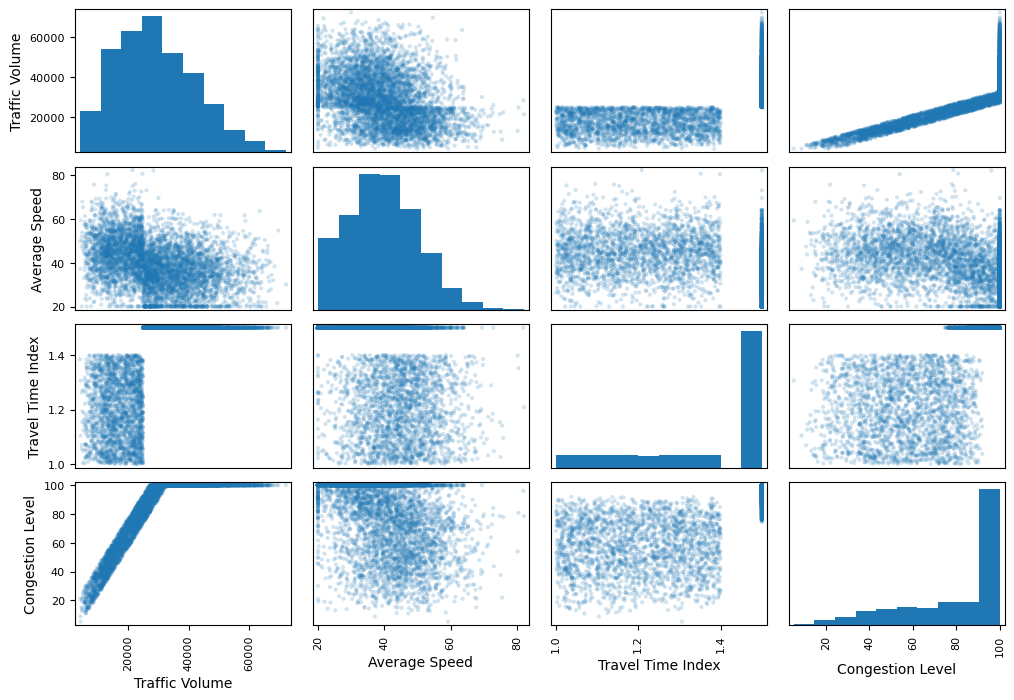

In [391]:
scatter_matrix(traffic_data[attributes], figsize=[12, 8], alpha=0.2);
plt.subplots_adjust(wspace=0.1, hspace=0.1)

## CORRELATION MATRIX

In [392]:
correlation_mat = traffic_data[['Traffic Volume',
       'Average Speed', 'Travel Time Index', 'Congestion Level',
       'Road Capacity Utilization', 'Pedestrian and Cyclist Count']].corr()

In [393]:
correlation_mat['Congestion Level'].sort_values(ascending=True)

Pedestrian and Cyclist Count   -0.750293
Average Speed                  -0.354983
Travel Time Index               0.754518
Traffic Volume                  0.840895
Road Capacity Utilization       0.869993
Congestion Level                1.000000
Name: Congestion Level, dtype: float64

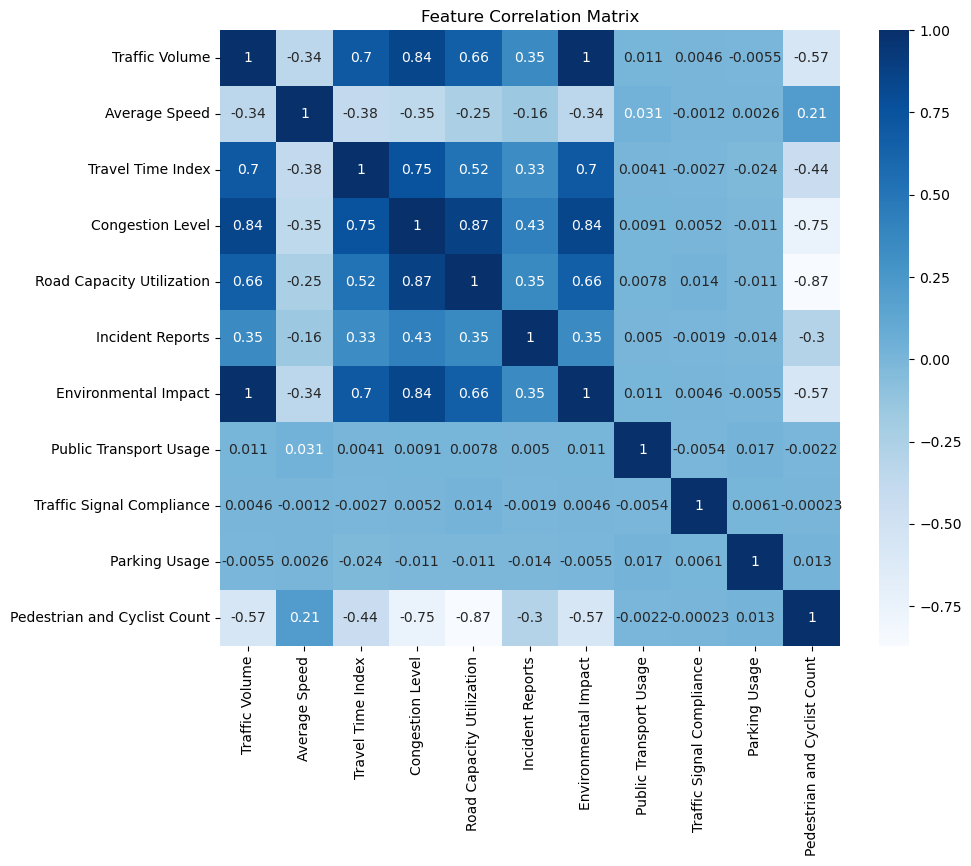

In [394]:
plt.figure(figsize=(10,8))
sns.heatmap(traffic_data.corr(numeric_only=True), annot=True, cmap='Blues')
plt.title('Feature Correlation Matrix')
plt.show() 

# CREATING TEST AND TRAIN DATAFRAMES - TIME BASED SPLIT

#### 2023 DATA FOR TRAINING AND 2024 DATA FOR TESTING

In [395]:
df_train = traffic_data[traffic_data['Date'].dt.year == 2023]
df_test = traffic_data[traffic_data['Date'].dt.year == 2024]

In [396]:
train_x = df_train[['Traffic Volume','Average Speed','Road Capacity Utilization', 'Incident Reports',
                    'Public Transport Usage', 'Traffic Signal Compliance']]
train_y = df_train['Congestion Level']
test_x = df_test[['Traffic Volume','Average Speed','Road Capacity Utilization', 'Incident Reports',
                    'Public Transport Usage', 'Traffic Signal Compliance']]
test_y = df_test['Congestion Level']

In [397]:
# STANDARDIZING DATA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

In [398]:
models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 
          'Polynomial Regression', 'Random Forest Regression']

summary_df = pd.DataFrame(columns=['Train R²','Test R²','Test MAE','Test RMSE','Test MAPE','Test MAXERR'],
                          index=models)

# FUNCTIONS

In [399]:
#PLOT ACTUAL VS PREDICTED VALUES
def plot_actual_vs_pred(test_y, y_test_pred):
    plt.scatter(test_y, y_test_pred, alpha=0.3)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted (Test Data)")
    plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'red')
    plt.show()

In [400]:
#EVALUATE REGRESSION MODEL
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, max_error
def evaluate_regression_model(train_y, train_pred, test_y, test_pred):
    r2_train = r2_score(y_true=train_y, y_pred=train_pred)
    r2_test = r2_score(y_true=test_y, y_pred=test_pred)

    mae = mean_absolute_error(y_true=test_y, y_pred=test_pred)
    rmse = np.sqrt(mean_squared_error(y_true=test_y, y_pred=test_pred))
    mape = mean_absolute_percentage_error(test_y, test_pred)
    maxerr = max_error(test_y, test_pred)

    print("Train R²:", round(r2_train, 3))
    print("Test R²:", round(r2_test, 3))
    print("Test MAE:", round(mae, 3))
    print("Test RMSE:", round(rmse, 3))
    print("Test MAPE:", round(mape, 3))
    print("Test MAXERR:", round(maxerr, 3))

    return [r2_train, r2_test, mae, rmse, mape, maxerr]

In [401]:
#PLOTTING K-FOLD CROSS-VALIDATION SCORES
def cross_val_plot(model,  train_x_scaled, train_y, cv=5):
    cvs_scores = cross_val_score(model, train_x_scaled, train_y, cv=5)
    print('Cross-Validation Scores: ', cvs_scores)
    plt.figure(figsize=[6,4])
    plt.bar(range(1,6), cvs_scores, color = 'teal')
    plt.xlabel("Folds")
    plt.ylabel("R² Score")
    plt.title("Cross-Validation Scores per Fold")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0,1)
    plt.show()

In [402]:
#RESIDUAL PLOT
def plot_residuals(test_y, y_test_pred):
    residuals = test_y - y_test_pred
    plt.figure(figsize=(8,5))
    plt.scatter(test_y, residuals, alpha=0.3)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Actual Values")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title("Residual Plot - Traffic Congestion Prediction")
    plt.show()

In [403]:
#FEATURE IMPORTANCE
def feature_importance_plot(model):
    coef_df = pd.DataFrame({
    'Feature': train_x.columns,
    'Coefficient': model.coef_
    }).sort_values(by='Coefficient', ascending=False)
    display(coef_df)

    coef_df.plot(kind='barh', x = 'Feature',xlabel='Feature', ylabel='Coefficient', figsize=[10, 8])
    plt.show()


In [404]:
#LEARNING CURVES
from sklearn.model_selection import learning_curve
def plot_learning_curve(model, X, y, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10), title='Learning Curve'):
    """
    Plots a learning curve for a regression model.

    Parameters:
    - model: estimator (e.g., RandomForestRegressor(), LinearRegression(), etc.)
    - X, y: data
    - cv: number of cross-validation folds
    - scoring: metric to evaluate (use 'r2', 'neg_mean_squared_error', etc.)
    - train_sizes: fraction of data used for training
    """
    
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes, n_jobs=-1
    )
    
    # Compute mean and std for plotting
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot
    plt.figure(figsize=(10,6))
    plt.title(title, fontsize=14)
    plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, val_mean, 'o-', color='b', label='Cross-validation score')
    plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1, color='g')
    plt.xlabel('Training Set Size')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


## LINEAR REGRESSION

In [405]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

In [406]:
lm.fit(train_x_scaled, train_y)

LinearRegression()

In [407]:
y_train_pred = lm.predict(train_x_scaled)
y_test_pred = lm.predict(test_x_scaled)

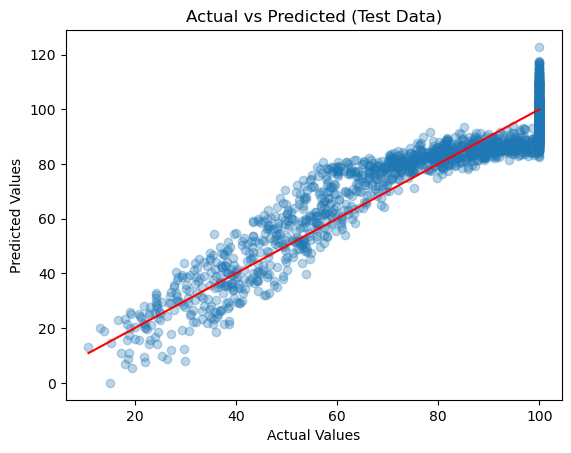

In [408]:
plot_actual_vs_pred(test_y, y_test_pred)

In [409]:
results = evaluate_regression_model(train_y, y_train_pred, test_y, y_test_pred)
summary_df.loc['Linear Regression'] = results

Train R²: 0.891
Test R²: 0.888
Test MAE: 6.5
Test RMSE: 7.873
Test MAPE: 0.095
Test MAXERR: 23.508


In [410]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(random_state=42)
sgd_reg.fit(train_x_scaled, train_y)

SGDRegressor(random_state=42)

Cross-Validation Scores:  [0.9025203  0.8931261  0.88449082 0.88351598 0.88335809]


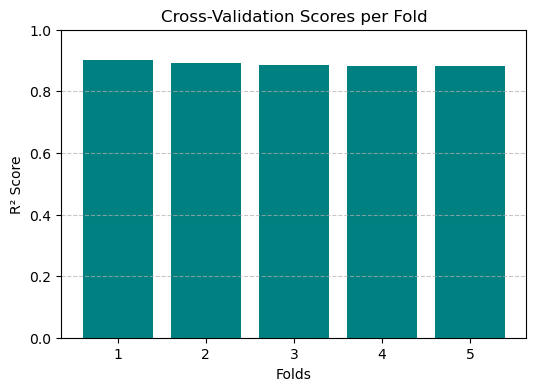

In [411]:
cross_val_plot(sgd_reg, train_x_scaled, train_y, cv = 5)

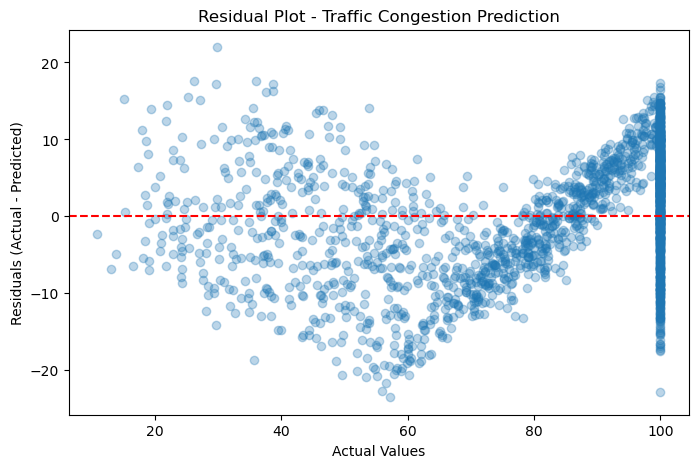

In [412]:
plot_residuals(test_y, y_test_pred)

,Feature,Coefficient
2,Road Capacity Utilization,12.965166
0,Traffic Volume,10.287487
3,Incident Reports,1.761295
4,Public Transport Usage,-0.019811
5,Traffic Signal Compliance,-0.098482
1,Average Speed,-1.554857


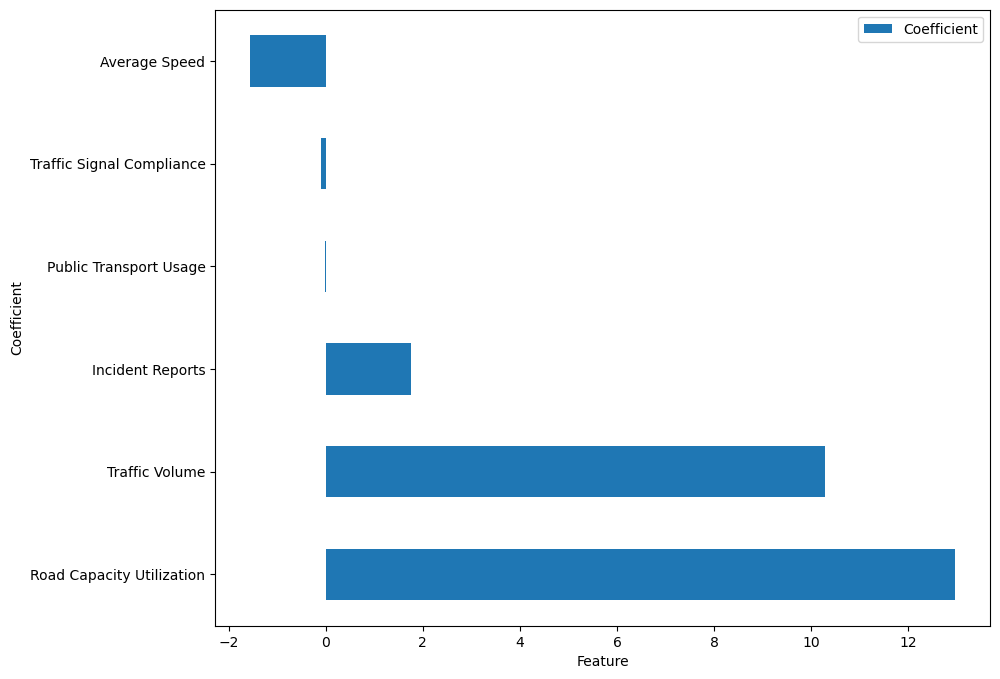

In [413]:
feature_importance_plot(lm)

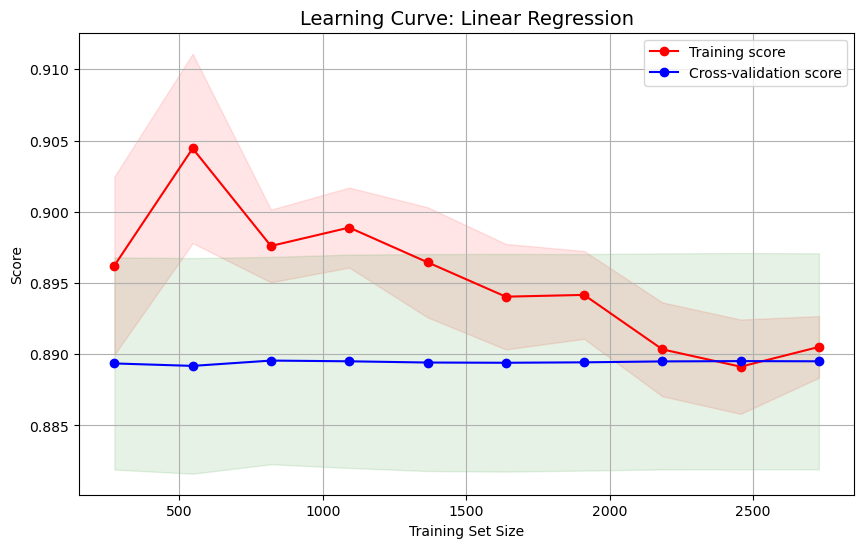

In [414]:
plot_learning_curve(lm, train_x_scaled, train_y, cv = 5, title='Learning Curve: Linear Regression')

# RIDGE REGRESSION

In [415]:
from sklearn.linear_model import Ridge
rdg = Ridge(alpha=100)
rdg.fit(train_x_scaled, train_y)

Ridge(alpha=100)

In [416]:
y_train_pred_rdg = rdg.predict(train_x_scaled)
y_test_pred_rdg = rdg.predict(test_x_scaled)

In [417]:
results = evaluate_regression_model(train_y, y_train_pred_rdg, test_y, y_test_pred_rdg)

Train R²: 0.89
Test R²: 0.888
Test MAE: 6.517
Test RMSE: 7.879
Test MAPE: 0.095
Test MAXERR: 23.524


In [418]:
ridge = Ridge()
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
grid.fit(train_x_scaled, train_y)

best_model = grid.best_estimator_

print("Best alpha:", grid.best_params_)
print("Best CV R²:", grid.best_score_)


Best alpha: {'alpha': 1}
Best CV R²: 0.889498666379718


In [419]:
#Fitting best model
y_train_pred_rdg = best_model.predict(train_x_scaled)
y_test_pred_rdg = best_model.predict(test_x_scaled)

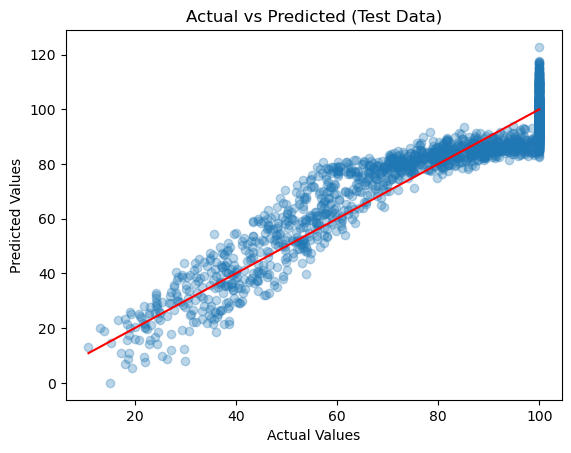

In [420]:
plot_actual_vs_pred(test_y, y_test_pred_rdg)

In [421]:
results = evaluate_regression_model(train_y, y_train_pred_rdg, test_y, y_test_pred_rdg)
summary_df.loc['Ridge Regression'] = results

Train R²: 0.891
Test R²: 0.888
Test MAE: 6.5
Test RMSE: 7.873
Test MAPE: 0.095
Test MAXERR: 23.508


Cross-Validation Scores:  [0.90274817 0.89328371 0.88462791 0.88358013 0.88324743]


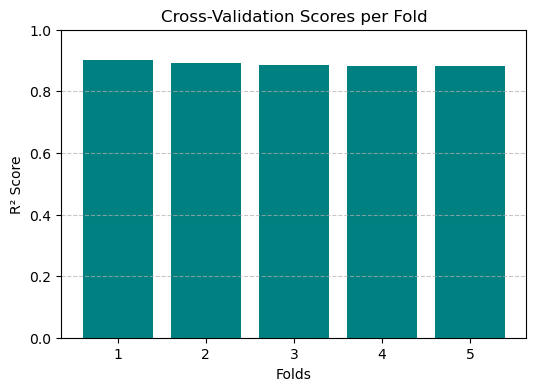

In [422]:
cross_val_plot(grid, train_x_scaled, train_y)

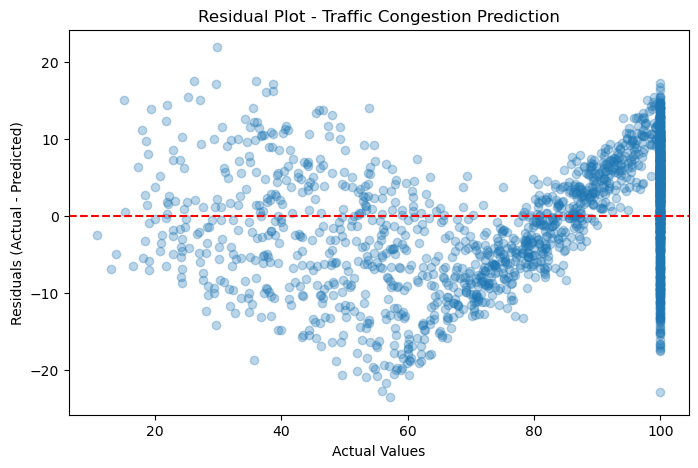

In [423]:
plot_residuals(test_y, y_test_pred_rdg)

,Feature,Coefficient
2,Road Capacity Utilization,12.961662
0,Traffic Volume,10.286164
3,Incident Reports,1.762355
4,Public Transport Usage,-0.019801
5,Traffic Signal Compliance,-0.098356
1,Average Speed,-1.555628


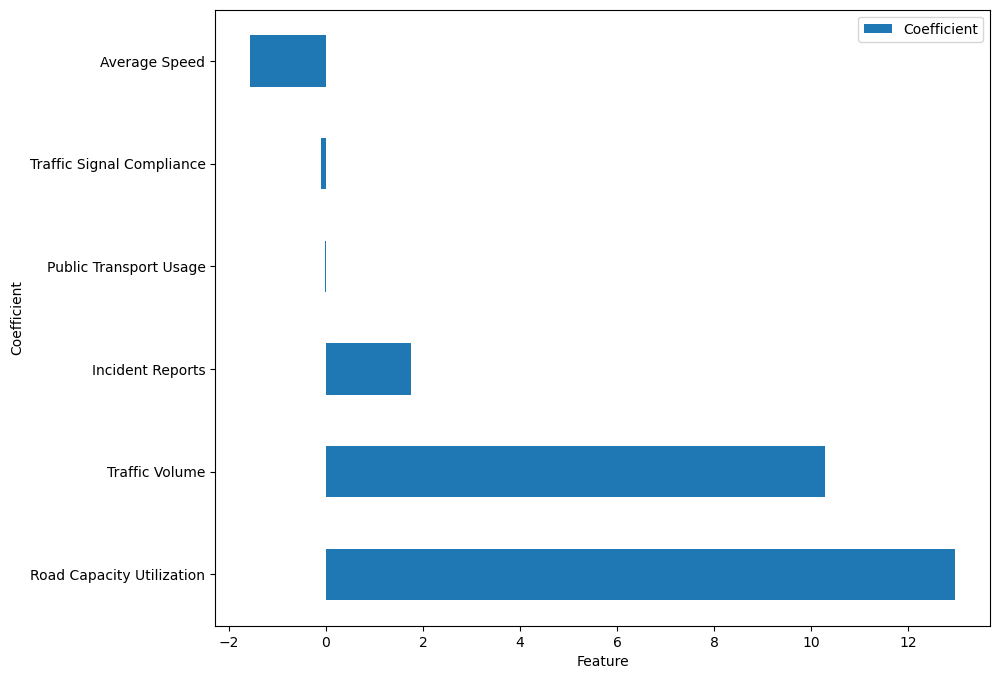

In [424]:
coef_df = pd.DataFrame({
    'Feature': train_x.columns,
    'Coefficient': best_model.coef_
}).sort_values(by='Coefficient', ascending=False)
display(coef_df)

coef_df.plot(kind='barh', x = 'Feature',xlabel='Feature', ylabel='Coefficient', figsize=[10, 8])
plt.show()


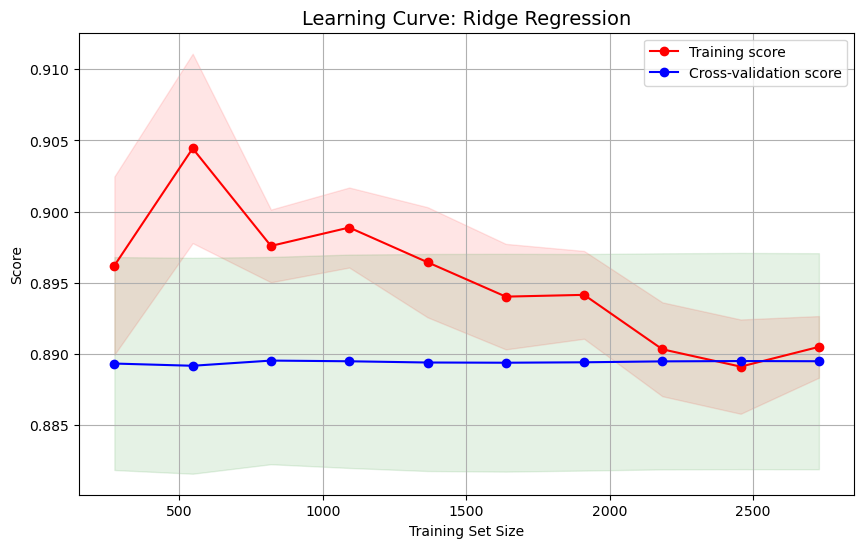

In [425]:
plot_learning_curve(best_model, train_x_scaled, train_y, cv = 5, title='Learning Curve: Ridge Regression')

# LASSO REGRESSION

In [426]:
from sklearn.linear_model import Lasso
lss = Lasso(alpha=5)
lss.fit(train_x_scaled, train_y)

Lasso(alpha=5)

In [427]:
y_traint_pred = lss.predict(train_x_scaled)
y_test_pred = lss.predict(test_x_scaled)

In [428]:
results = evaluate_regression_model(train_y, y_train_pred, test_y, y_test_pred)

Train R²: 0.891
Test R²: 0.831
Test MAE: 8.277
Test RMSE: 9.69
Test MAPE: 0.131
Test MAXERR: 24.385


In [429]:
lasso = Lasso(max_iter=10000)
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(lasso, param_grid, cv=5, scoring='r2')
grid.fit(train_x_scaled, train_y)

best_model = grid.best_estimator_

print("Best alpha:", grid.best_params_)
print("Best CV R²:", grid.best_score_)

Best alpha: {'alpha': 0.01}
Best CV R²: 0.8895030629409864


In [430]:
#Fitting best model
y_train_pred = best_model.predict(train_x_scaled)
y_test_pred = best_model.predict(test_x_scaled)

In [431]:
results = evaluate_regression_model(train_y, y_train_pred, test_y, y_test_pred)
summary_df.loc['Lasso Regression'] = results

Train R²: 0.891
Test R²: 0.888
Test MAE: 6.5
Test RMSE: 7.872
Test MAPE: 0.095
Test MAXERR: 23.499


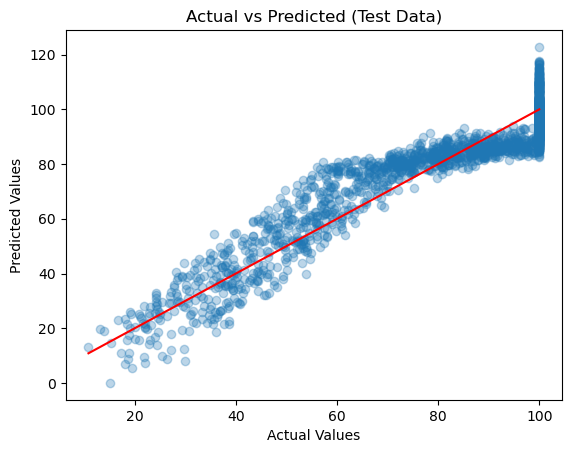

In [432]:
plot_actual_vs_pred(test_y, y_test_pred)

Cross-Validation Scores:  [0.90276517 0.89327729 0.88465125 0.88355917 0.88326242]


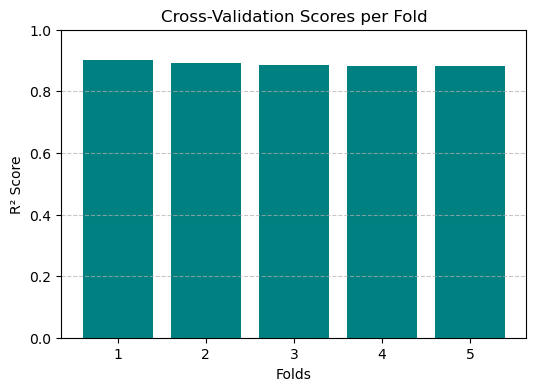

In [433]:
cross_val_plot(best_model, train_x_scaled, train_y, cv = 5)

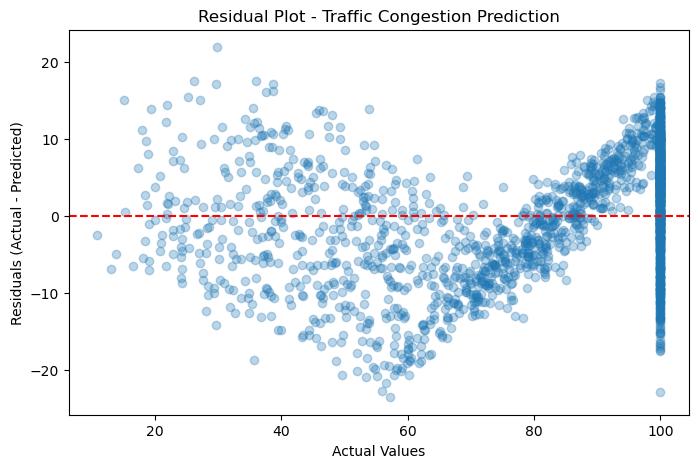

In [434]:
plot_residuals(test_y, y_test_pred)

,Feature,Coefficient
2,Road Capacity Utilization,12.960537
0,Traffic Volume,10.285260
3,Incident Reports,1.754645
4,Public Transport Usage,-0.009633
5,Traffic Signal Compliance,-0.088456
1,Average Speed,-1.548397


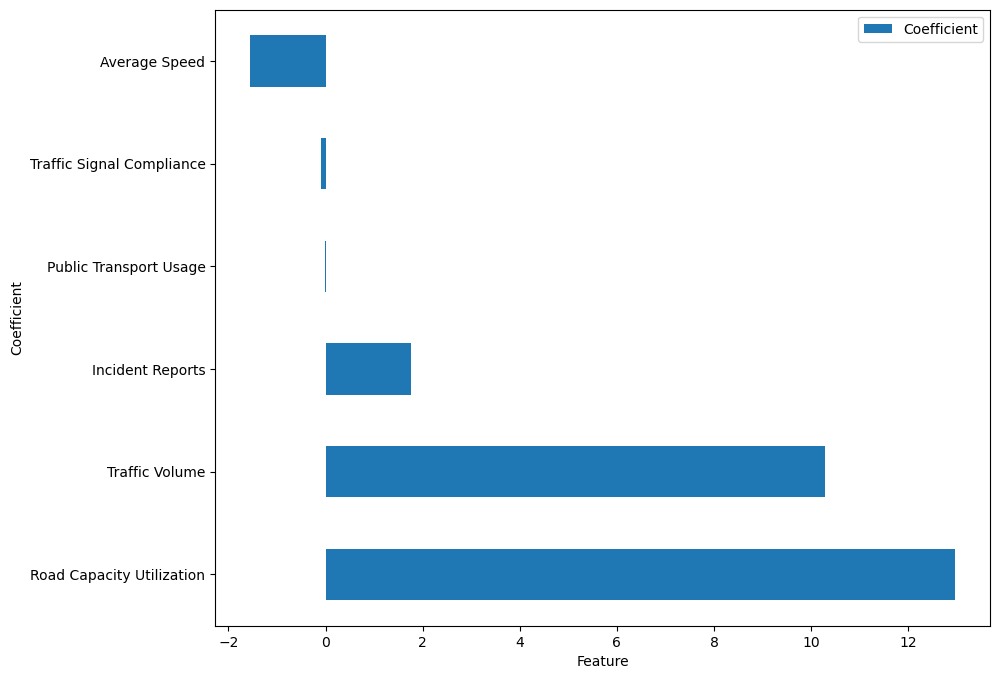

In [435]:
feature_importance_plot(best_model)


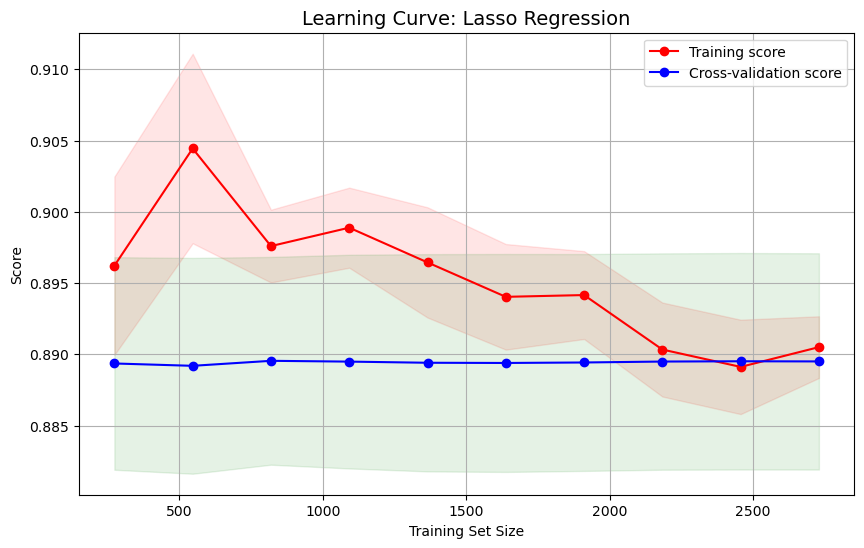

In [436]:
plot_learning_curve(best_model, train_x_scaled, train_y, cv = 5, title='Learning Curve: Lasso Regression')

## POLYNOMIAL REGRESSION

In [437]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(train_x_scaled)
poly.fit(X_poly, train_y)

lm2 = LinearRegression()
lm2.fit(X_poly, train_y)

LinearRegression()

In [438]:
# lm2 was trained on polynomial features; transform inputs the same way before predicting
y_train_pred_poly = lm2.predict(poly.fit_transform(train_x_scaled))
y_test_pred_poly = lm2.predict(poly.transform(test_x_scaled))

In [439]:
results = evaluate_regression_model(train_y, y_train_pred_poly, test_y, y_test_pred_poly)

Train R²: 0.95
Test R²: 0.951
Test MAE: 4.25
Test RMSE: 5.209
Test MAPE: 0.065
Test MAXERR: 21.796


In [440]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

param_grid = {
    'poly__degree': [1, 2, 3, 4, 5],   
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(train_x_scaled, train_y)
print(grid.best_params_)
best_model = grid.best_estimator_

{'poly__degree': 3}


In [441]:
y_train_pred_poly = best_model.predict(train_x_scaled)
y_test_pred_poly = best_model.predict(test_x_scaled)

In [442]:
results = evaluate_regression_model(train_y, y_train_pred_poly, test_y, y_test_pred_poly)
summary_df.loc['Polynomial Regression'] = results

Train R²: 0.966
Test R²: 0.965
Test MAE: 3.398
Test RMSE: 4.435
Test MAPE: 0.056
Test MAXERR: 14.838


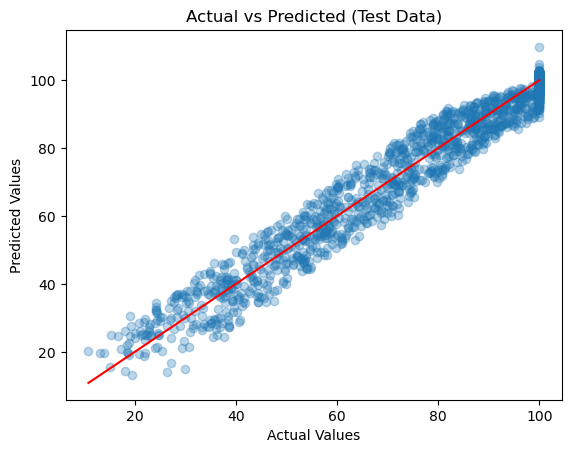

In [443]:
plot_actual_vs_pred(test_y, y_test_pred_poly)


In [444]:
from sklearn.pipeline import make_pipeline
poly_reg_pipeline = make_pipeline(
    PolynomialFeatures(degree=3), #best degree obtained from fine tuning  = 3
    LinearRegression()
)
scores = cross_val_score(poly_reg_pipeline, train_x, train_y, cv=5)
print("Cross-validation R² scores:", scores)

Cross-validation R² scores: [0.96900074 0.96255852 0.96451269 0.96014142 0.96144975]


Cross-Validation Scores:  [0.96897414 0.96206823 0.96437681 0.95950332 0.96051166]


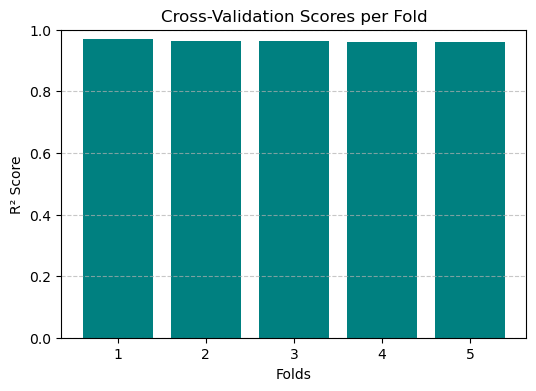

In [445]:
cross_val_plot(best_model, train_x_scaled, train_y, cv= 5)

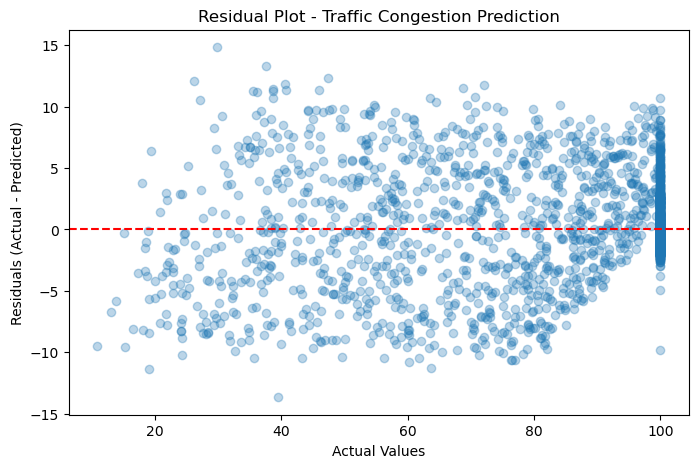

In [446]:
plot_residuals(test_y, y_test_pred_poly)

,Feature,Coefficient,AbsCoefficient
38,Traffic Volume Road Capacity Utilization^2,77.575558,77.575558
0,Traffic Volume,42.801837,42.801837
17,Road Capacity Utilization^2,27.441989,27.441989
27,Traffic Volume^3,14.512861,14.512861
34,Traffic Volume Average Speed Road Capacity Uti...,5.137750,5.137750
13,Average Speed Road Capacity Utilization,2.458057,2.458057
65,Road Capacity Utilization^2 Public Transport U...,1.468675,1.468675
18,Road Capacity Utilization Incident Reports,0.987329,0.987329
30,Traffic Volume^2 Incident Reports,0.769676,0.769676
10,Traffic Volume Public Transport Usage,0.755896,0.755896


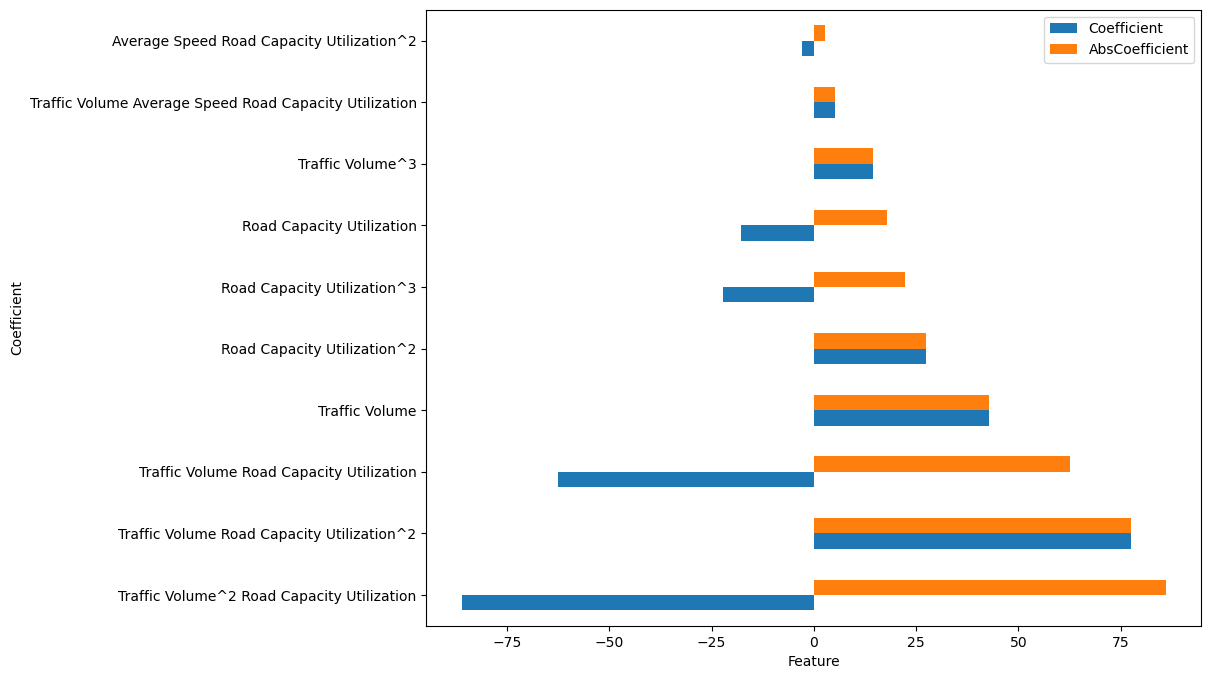

In [447]:
# Get feature names from polynomial features
poly = best_model.named_steps['poly']
feature_names = poly.get_feature_names_out(train_x.columns)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': best_model.named_steps[('model')].coef_
}).sort_values(by='Coefficient', ascending=False)
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
top_features = coef_df.sort_values(by='AbsCoefficient', ascending=False).head(10)
display(coef_df.head(10))

top_features.plot(kind='barh', x = 'Feature',xlabel='Feature', ylabel='Coefficient', figsize=[10, 8])
plt.show()

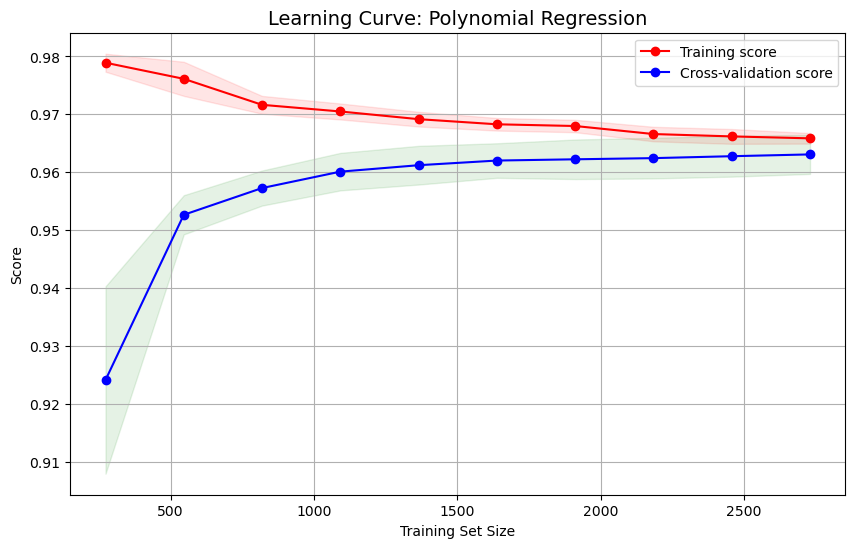

In [448]:
plot_learning_curve(best_model, train_x_scaled, train_y, cv = 5, title='Learning Curve: Polynomial Regression')

# RANDOM FOREST REGRESSOR

In [449]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rfr = RandomForestRegressor(random_state=42)

param_distributions = {
    'n_estimators': np.arange(100, 1001, 100),        # 100 to 1000
    'max_depth': [None] + list(range(2, 21, 2)),      
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 5),             
    'max_features': ['auto', 'sqrt', 'log2'],         # feature subset
    'bootstrap': [True, False]                        # bootstrap sampling
}

random_search = RandomizedSearchCV(
    estimator=rfr,
    param_distributions=param_distributions,
    n_iter=50,             
    cv=5,                  # 5-fold cross-validation
    scoring='r2',          # or 'neg_mean_squared_error'
    n_jobs=-1,             # use all available cores
    verbose=2,
    random_state=42
)

random_search.fit(train_x_scaled, train_y)
print("Best Parameters Found:")
print(random_search.best_params_)
print("\nBest Cross-Validation R² Score:", round(random_search.best_score_, 4))

best_rfr = random_search.best_estimator_
best_rfr.fit(train_x_scaled, train_y)
y_train_pred = best_rfr.predict(train_x_scaled)
y_test_pred = best_rfr.predict(test_x_scaled)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters Found:
{'n_estimators': np.int64(400), 'min_samples_split': np.int64(8), 'min_samples_leaf': np.int64(2), 'max_features': 'log2', 'max_depth': 14, 'bootstrap': True}

Best Cross-Validation R² Score: 0.9651


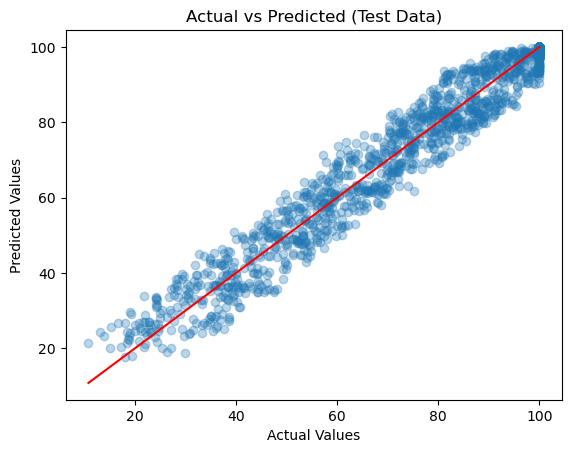

In [450]:
plot_actual_vs_pred(test_y, y_test_pred)

In [451]:
results = evaluate_regression_model(train_y, y_train_pred, test_y, y_test_pred)
summary_df.loc['Random Forest Regression'] = results

Train R²: 0.986
Test R²: 0.966
Test MAE: 2.975
Test RMSE: 4.324
Test MAPE: 0.053
Test MAXERR: 14.26


Cross-Validation Scores:  [0.96952089 0.96463277 0.96645677 0.96293066 0.96178929]


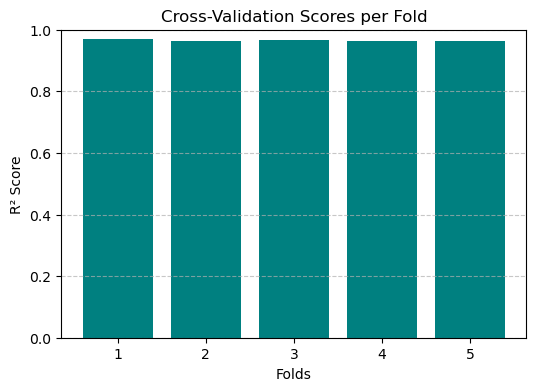

In [452]:
cross_val_plot(best_rfr, train_x_scaled, train_y)

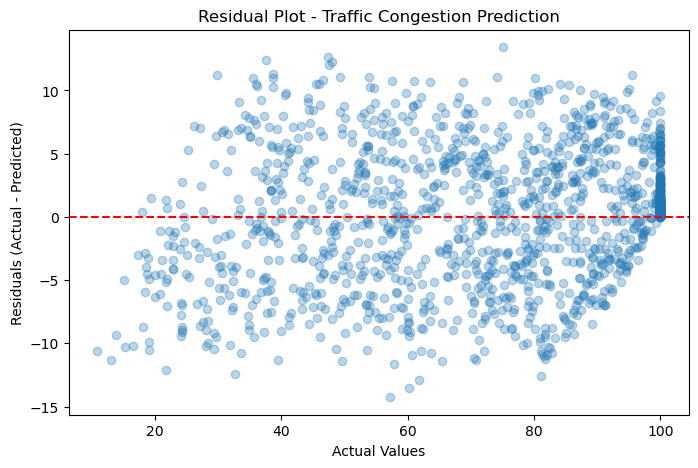

In [453]:
plot_residuals(test_y, y_test_pred)

,Feature,Coefficient
0,Traffic Volume,0.539116
2,Road Capacity Utilization,0.363050
3,Incident Reports,0.051717
1,Average Speed,0.031663
5,Traffic Signal Compliance,0.007548
4,Public Transport Usage,0.006906


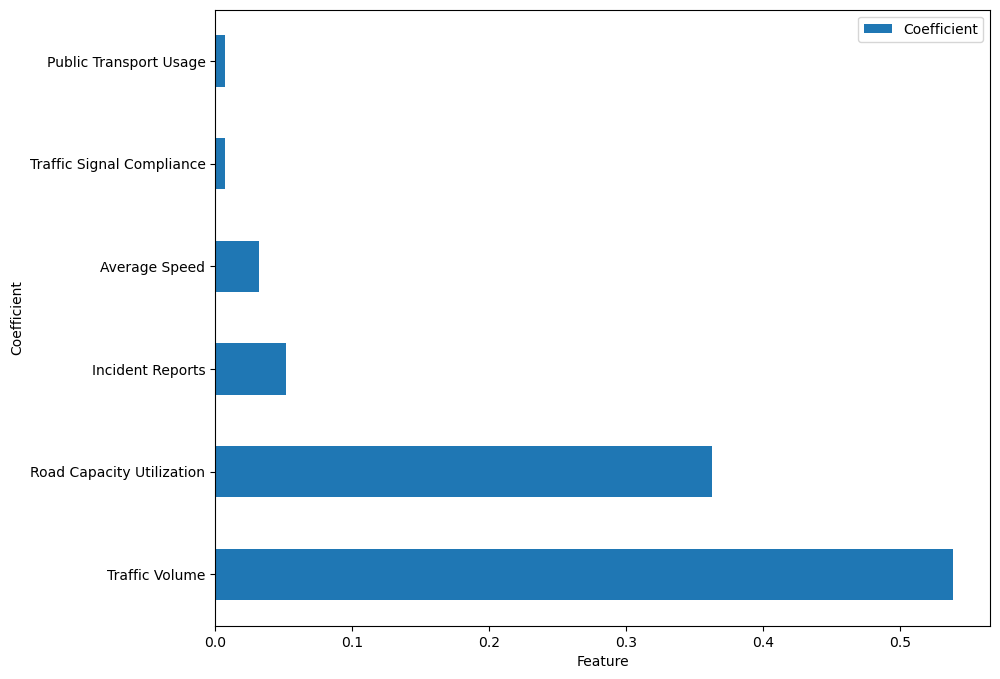

In [454]:
coef_df = pd.DataFrame({
    'Feature': train_x.columns,
    'Coefficient': best_rfr.feature_importances_
}).sort_values(by='Coefficient', ascending=False)
display(coef_df)

coef_df.plot(kind='barh', x = 'Feature',xlabel='Feature', ylabel='Coefficient', figsize=[10, 8])
plt.show()


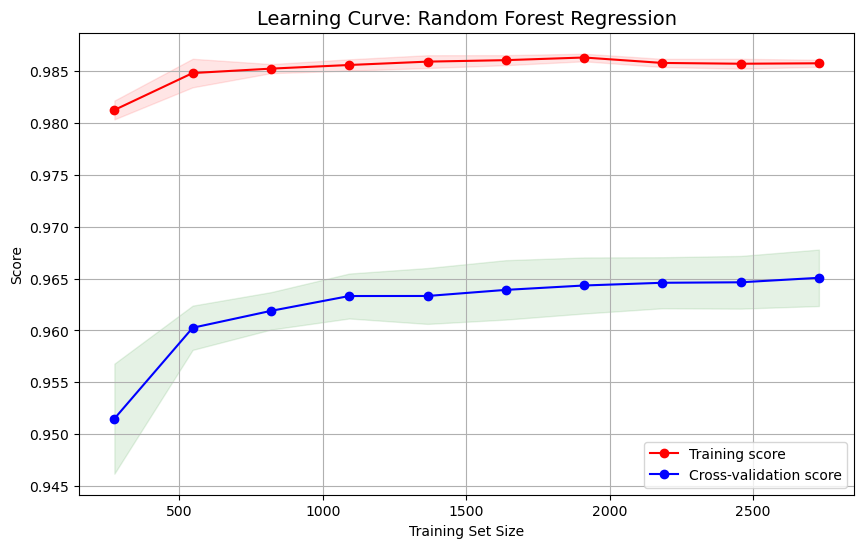

In [455]:
plot_learning_curve(best_rfr, train_x_scaled, train_y, cv = 5, title='Learning Curve: Random Forest Regression')

# COMPARING MODEL PERFOMANCES

In [456]:
summary_df

,Train R²,Test R²,Test MAE,Test RMSE,Test MAPE,Test MAXERR
Linear Regression,0.890502,0.888125,6.500109,7.87292,0.095359,23.508328
Ridge Regression,0.890502,0.888126,6.500231,7.872879,0.095359,23.508446
Lasso Regression,0.890501,0.888141,6.500125,7.872351,0.095356,23.499362
Polynomial Regression,0.965639,0.964505,3.398206,4.434598,0.056326,14.838041
Random Forest Regression,0.985793,0.966252,2.975304,4.324052,0.052611,14.260056


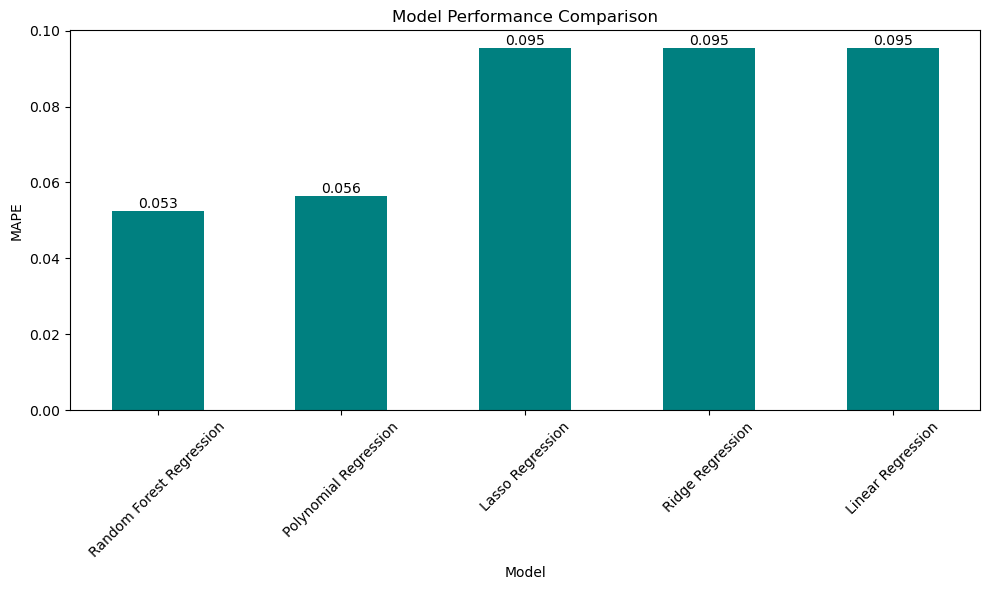

In [ ]:
plt.figure(figsize=[10,6])
bars = plt.bar(summary_df.sort_values('Test MAPE').index, 
               summary_df['Test MAPE'].sort_values(ascending=True), 
               width=0.5, 
               color='teal', 
               )

plt.xlabel('Model')
plt.ylabel('MAPE')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.tight_layout()

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,     
             height,                              
             f'{height:.3f}',                     
             ha='center', va='bottom', fontsize=10)

plt.show()


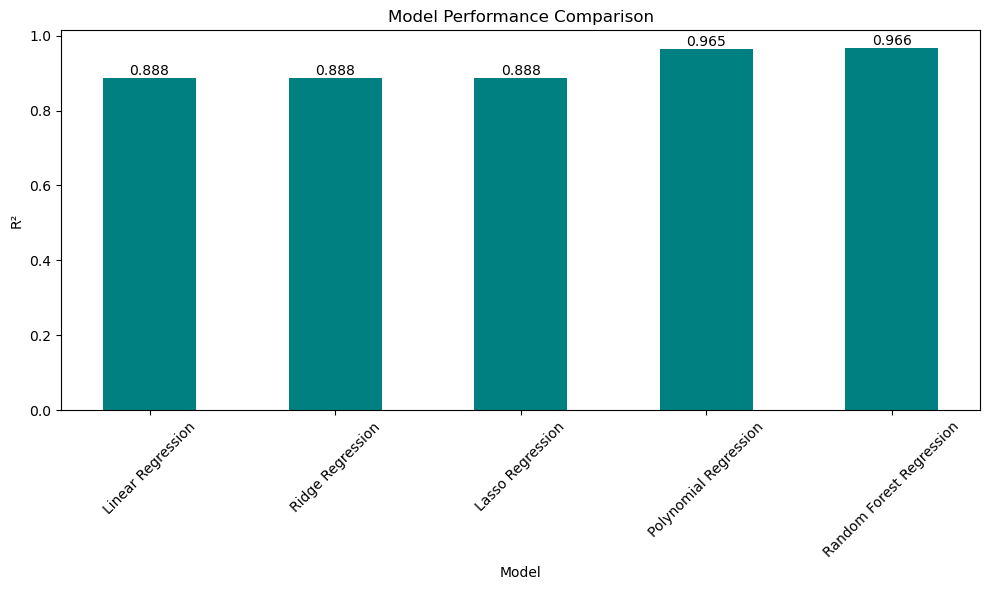

In [473]:
plt.figure(figsize=[10,6])
bars = plt.bar(summary_df.sort_values('Test R²').index, 
               summary_df['Test R²'].sort_values(ascending=True), 
               width=0.5, 
               color='teal', 
               )

plt.xlabel('Model')
plt.ylabel('R²')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.tight_layout()

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,     
             height,                              
             f'{height:.3f}',                     
             ha='center', va='bottom', fontsize=10)

plt.show()
